### Load cleaned data and pre-defined classes

In [132]:
from data_clean import Data_to_Clean,Data_to_Analyze
import pickle
import pandas as pd
import copy
MBTI_types=[
    "ISTJ", "ISFJ", "INFJ", "INTJ",
    "ISTP", "ISFP", "INFP", "INTP",
    "ESTP", "ESFP", "ENFP", "ENTP",
    "ESTJ", "ESFJ", "ENFJ", "ENTJ"
]
cleaned_data=dict.fromkeys(MBTI_types, None)

for type in cleaned_data.keys():
    file_path=f"Data\\cleaned_data\\{type}_cleaned.pkl" 
    try:
        with open(file_path, 'rb') as f:
            cleaned_data[type] = pickle.load(f)
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
    except pickle.UnpicklingError:
        print(f"Error: Could not unpickle the file {file_path}. It might be corrupted or not a valid pickle file.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")


In [133]:
import gensim.downloader as api  
import numpy as np 
model_name = "glove-wiki-gigaword-100" # 100维 GloVe 向量  
try:  
    print(f"\n正在加载预训练模型 '{model_name}'...")  
    word_embedding_model = api.load(model_name)  
    print("模型加载成功。")  
    vector_size = word_embedding_model.vector_size # 获取向量维度  
except Exception as e:  
    print(f"加载预训练模型失败: {e}。请检查网络连接或模型名称。")  
    word_embedding_model = None  
    vector_size = 100 # 假设一个默认维度以便代码继续 


正在加载预训练模型 'glove-wiki-gigaword-100'...
模型加载成功。


In [134]:
class Data_to_Model:
    def __init__(self,source):
        self.data=source.data
        self.data_to_vec=source.data_to_vec
        self.basic_identities=source.basic_identities
        self.post_vec=None
    def text_to_vec(self):
        def process_to_vec(post):
            post_to_vec=[]
            # 获取模型词汇表集合，用于快速查找  
            index2word_set = set(word_embedding_model.index_to_key) if hasattr(word_embedding_model, 'index_to_key') else set(word_embedding_model.key_to_index.keys())
            for tokens in post:
                feature_vec = np.zeros((vector_size,), dtype="float32")  
                nwords = 0.  
                for word in tokens: 
                    if word in index2word_set:
                        nwords+=1
                        feature_vec=np.add(feature_vec,word_embedding_model[word]) 
                if nwords>0:          
                    feature_vec=np.divide(feature_vec,nwords)
                else:
                    feature_vec=np.zeros((vector_size,), dtype="float32")
                post_to_vec.append(feature_vec)
            return post_to_vec
        self.post_vec=copy.deepcopy(self.data_to_vec)
        self.post_vec["posts"]=self.post_vec["posts"].apply(process_to_vec)
    def aggregate_post_vec(self):
        def process_aggregate(post):
            valid_vecs=[sentence for sentence in post if isinstance(sentence,np.ndarray) and sentence.shape==(vector_size,)]
            return np.mean(valid_vecs,axis=0)
        self.post_vec["posts"]=self.post_vec["posts"].apply(process_aggregate)

In [135]:
infp=Data_to_Model(cleaned_data["INFP"])
infp.data

,type,posts,vader_score
0,INFP,"[[think, agree, personally, consider, alpha, b...","{'neg': 0.068, 'neu': 0.734, 'pos': 0.198, 'co..."
1,INFP,"[[normal, happens, also, high, mood, act, like...","{'neg': 0.05, 'neu': 0.771, 'pos': 0.179, 'com..."
2,INFP,"[[urh, sorry, uh, could, resist], [enfjs, plea...","{'neg': 0.034, 'neu': 0.749, 'pos': 0.218, 'co..."
3,INFP,"[[personally, think, would, sj, type, job, way...","{'neg': 0.086, 'neu': 0.749, 'pos': 0.165, 'co..."
4,INFP,"[[basically, main, question, believe, value, m...","{'neg': 0.046, 'neu': 0.753, 'pos': 0.2, 'comp..."
...,...,...,...
1827,INFP,"[[enjoy, infps], [okok, let, stop, kick, walk,...","{'neg': 0.169, 'neu': 0.692, 'pos': 0.139, 'co..."
1828,INFP,"[[whatever, want, private, person, maybe, mean...","{'neg': 0.079, 'neu': 0.784, 'pos': 0.137, 'co..."
1829,INFP,"[[love, vastness, sky, problem, sadness, alway...","{'neg': 0.087, 'neu': 0.782, 'pos': 0.131, 'co..."
1830,INFP,"[[conflict, right, come, want, child, honestly...","{'neg': 0.057, 'neu': 0.801, 'pos': 0.141, 'co..."


In [136]:
infp.basic_identities

type                                                                  INFP
sentence_quantity        [50, 50, 28, 50, 48, 50, 50, 50, 50, 50, 42, 5...
ave_sentence_quantity                                            49.015284
word_count               [1687, 1254, 692, 1201, 1543, 1719, 1540, 1483...
ave_word_count                                                 1328.991812
upper_ratio              [0.03705767623293396, 0.0456968773800457, 0.04...
ave_upper_ratio                                                   0.049654
reading_ease             [67.96, 67.55, 78.55, 76.72, 75.71, 76.42, 76....
ave_reading_ease                                                 73.241829
GF_index                 [7.68, 8.2, 6.64, 6.75, 7.12, 6.7, 9.7, 7.04, ...
ave_GF_index                                                       7.73065
overall_vader_score      {'neg': 0.08518176855895165, 'neu': 0.74737390...
dtype: object

In [159]:
all_vader_scores={T:cleaned_data[T].basic_identities["overall_vader_score"] for T in MBTI_types}

In [ ]:
all_vader_scores=pd.DataFrame(all_vader_scores).T

,neg,neu,pos,compound
ISTJ,0.077654,0.773000,0.149322,0.916729
ISFJ,0.077181,0.750910,0.171873,0.916888
INFJ,0.080331,0.755339,0.164369,0.945978
INTJ,0.083156,0.769997,0.146838,0.853628
ISTP,0.088647,0.767401,0.143926,0.834455
ISFP,0.079070,0.750716,0.170199,0.931673
INFP,0.085182,0.747374,0.167451,0.903630
INTP,0.086054,0.769654,0.144281,0.830813
ESTP,0.082472,0.758079,0.159348,0.929774
ESFP,0.080125,0.759917,0.159896,0.896377


In [172]:
all_vader_scores=all_vader_scores.sort_values(by="pos",ascending=False)

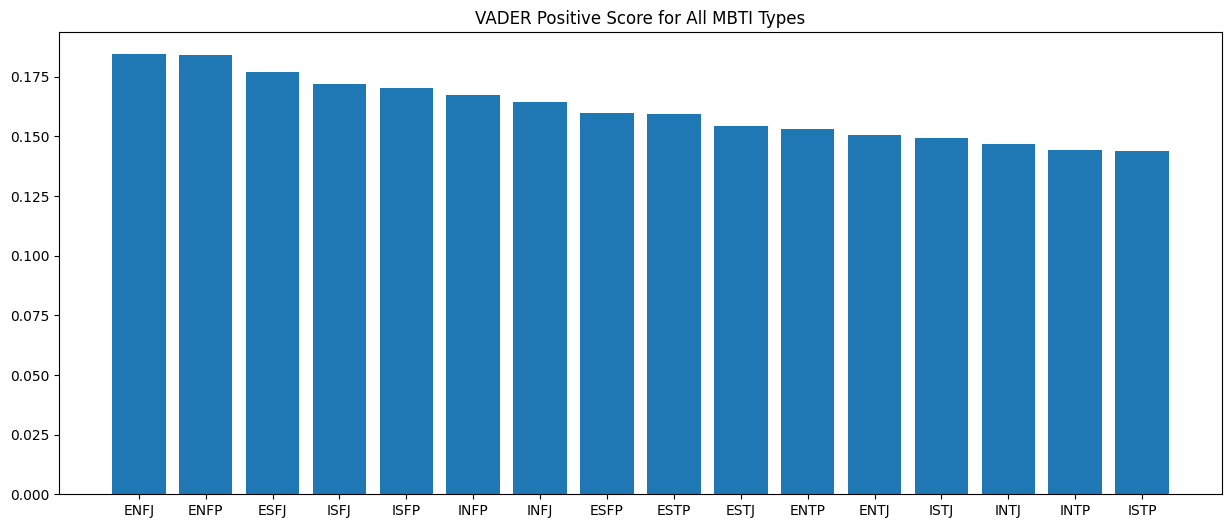

In [173]:
import matplotlib.pyplot as plt
x=all_vader_scores.index
y=all_vader_scores["pos"]
plt.figure(figsize=(15, 6))
plt.bar(x,y)
plt.title("VADER Positive Score for All MBTI Types")
plt.show()